**Plan of the work:**

1)take model

2)take default CIFAR100 dataset

3)construct  3 subdatasets:


*   10 hard classes only
*   10 easy classes only
*   10 random classes


4)for fixed n_epochs measure acc after adv training on each dataset

6)compare results.





In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pickle
from torchvision import datasets, transforms
from tqdm import tqdm
from copy import deepcopy
from collections import OrderedDict
import matplotlib.pyplot as plt
from utils import set_seed,get_device,get_loaders,clamp,get_label,get_loader,prepare_transforms
from network import PreActResNet18
from train_utils import attack_pgd,evaluate_pgd,evaluate_standard

In [2]:
set_seed(42)

#Model

In [3]:
device = get_device()

model = PreActResNet18(num_classes=10).to(device)

print(device)

cuda


#Adv training on default dataset

In [4]:
weight_decay = 5e-4
epsilon = 8
batch_size = 32
alpha = 2
loss_weight = 0.3
fgsm_step = 1
delta_init = 'random'
model.train()
scaler = torch.cuda.amp.GradScaler()
criterion = nn.CrossEntropyLoss()

data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)

mu = torch.tensor(data_mean).view(3, 1, 1).to(device)
std = torch.tensor(data_std).view(3, 1, 1).to(device)
upper_limit = ((1 - mu) / std)
lower_limit = ((0 - mu) / std)
epsilon = (epsilon / 255.) / std
alpha = (alpha / 255.) / std

if delta_init == 'previous':
    delta = torch.zeros(batch_size, 3, 32, 32).to(device)

prev_robust_acc = 0.

In [5]:
NUM_CLASSES = 10

In [6]:
epochs = 30

In [7]:
hard_classes = [13,35,55,72,96,10,44,65,74,4]
easy_classes = [8,9,20,87,94,21,41,39,53,68]
random_classes = list(np.unique(np.random.randint(0,100,20)))[:10]

In [8]:
print(random_classes)

[1, 2, 14, 20, 21, 23, 29, 37, 51, 52]


In [9]:
keys = ['hard','easy','random']

X_train = dict()
X_test = dict()

y_train = dict()
y_test = dict()

dicts = [X_train,X_test,y_train,y_test]
for key in keys:
  for d in dicts:
    d[key] = []

In [10]:
classes = dict()
classes['easy'] = easy_classes
classes['hard'] = hard_classes
classes['random'] = random_classes

labels = ['hard','easy','random']

labels_match = dict()
for label in labels:
  labels_match[label] = {class_label : idx for idx,class_label in enumerate(classes[label])}
print(labels_match)

def targets_rewrite(targets,mapping):
  targets = [mapping[t.item()] for t in targets]
  return torch.LongTensor(targets)

print(targets_rewrite(torch.Tensor([8]),labels_match['easy']))

{'hard': {13: 0, 35: 1, 55: 2, 72: 3, 96: 4, 10: 5, 44: 6, 65: 7, 74: 8, 4: 9}, 'easy': {8: 0, 9: 1, 20: 2, 87: 3, 94: 4, 21: 5, 41: 6, 39: 7, 53: 8, 68: 9}, 'random': {1: 0, 2: 1, 14: 2, 20: 3, 21: 4, 23: 5, 29: 6, 37: 7, 51: 8, 52: 9}}
tensor([0])


In [11]:
train_transform, test_transform = prepare_transforms(augments=[False,False])


data_dir = 'cifar-100'
train_dataset = datasets.CIFAR100(data_dir, train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR100(data_dir, train=False, transform=test_transform, download=True)
data_train,targets_train = train_dataset.data,torch.LongTensor(train_dataset.targets)
data_test,targets_test = test_dataset.data,torch.LongTensor(test_dataset.targets)

for label in labels:
  for c in classes[label]:
    X_c_train, y_c_train = data_train[targets_train==c], targets_train[targets_train==c]
    X_c_test, y_c_test = data_test[targets_test==c], targets_test[targets_test==c]

    X_train[label].append(X_c_train)
    y_train[label].append(targets_rewrite(y_c_train,labels_match[label]))
    X_test[label].append(X_c_test)
    y_test[label].append(targets_rewrite(y_c_test,labels_match[label]))

Files already downloaded and verified
Files already downloaded and verified


In [12]:
train_loaders = dict()
test_loaders = dict()

for label in labels:
  train_loaders[label] = get_loader(data_dir,X_train[label],y_train[label],32)
  test_loaders[label] = get_loader(data_dir,X_test[label],y_test[label],32,train=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
t_l = train_loaders['easy']
for x,y in t_l:
  print(y)
  print(y.shape)
  x = x.to(device)
  y = y.to(device)
  logits = model(x)
  print(logits.shape)
  loss = F.cross_entropy(logits,y)
  print(loss)
  break

tensor([3, 0, 3, 0, 2, 3, 5, 5, 6, 8, 5, 4, 2, 2, 9, 9, 6, 9, 4, 9, 1, 7, 6, 9,
        7, 0, 1, 2, 4, 4, 4, 3])
torch.Size([32])
torch.Size([32, 10])
tensor(2.3324, device='cuda:0', grad_fn=<NllLossBackward0>)


In [14]:
acc_train_history = dict()
acc_pgd_val_history = dict()
acc_st_val_history = dict()

for label in labels:
  acc_train_history[label] = []
  acc_pgd_val_history[label] = []
  acc_st_val_history[label] = []

In [15]:
epochs = 50

In [16]:
for label in labels:
  model = PreActResNet18(num_classes=10).to(device)
  optimizer = torch.optim.Adam(model.parameters(),lr=3e-4,weight_decay=weight_decay)
  loop = tqdm(range(epochs))
  for epoch in loop:
      train_loss,train_acc,train_n = 0,0,0
      model.train()
      for i, (X, y) in enumerate(train_loaders[label]):
          optimizer.zero_grad()
          X, y = X.to(device), y.to(device)
          if delta_init != 'previous':
              delta = torch.zeros_like(X).to(device)
          if delta_init == 'random':
              for j in range(len(epsilon)):
                  delta[:, j, :, :].uniform_(-epsilon[j][0][0].item(), epsilon[j][0][0].item())
              delta.data = clamp(delta, lower_limit - X, upper_limit - X)
          if fgsm_step == 1:
              delta.requires_grad = True
              for _ in range(1):
                  output = model(X + delta[:X.size(0)])
                  loss = F.cross_entropy(output, y)
                  scaler.scale(loss).backward()
                  grad = delta.grad.detach()
                  scaler.step(optimizer)
                  scaler.update()
                  delta.data = clamp(delta + alpha * torch.sign(grad), -epsilon, epsilon)
                  delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
              delta = delta.detach()
              output = model(X + delta[:X.size(0)])
              loss = (1 - loss_weight) * criterion(output, y) + loss_weight * criterion(model(X), y)
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()
              
          train_loss += loss.item() * y.size(0)
          train_acc += (output.max(1)[1] == y).sum().item()
          train_n += y.size(0)
        
      acc_train_history[label].append(train_acc / train_n)
      model.eval()
      pgd_loss, pgd_acc, acc_cl_pgd_at = evaluate_pgd(test_loaders[label], model, 1, 5, epsilon, alpha, 
                                    lower_limit, upper_limit,device)
      acc_pgd_val_history[label].append(pgd_acc)
      st_loss, st_acc, acc_cl_st_at = evaluate_standard(test_loaders[label], model,device)
      acc_st_val_history[label].append(st_acc)
        
      loop.set_description(f'train acc: {round(train_acc / train_n,3)} test acc: {round(pgd_acc,3)} {label}')

train acc: 0.923 test acc: 0.723 random: 100%|██████████| 50/50 [09:32<00:00, 11.44s/it]


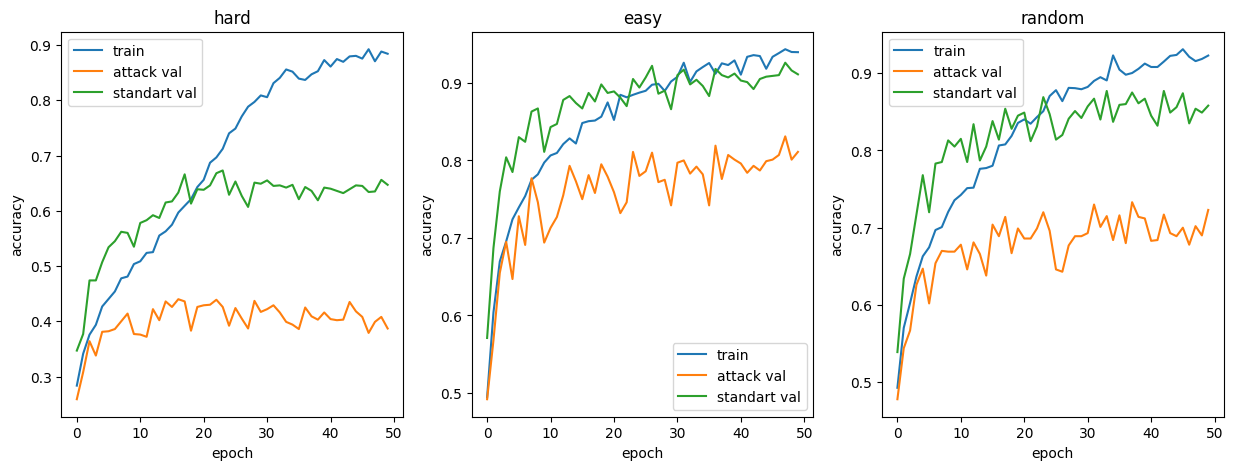

In [18]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for ax,label in zip(axes,labels):
  ax.plot(range(epochs),acc_train_history[label],label='train')
  ax.plot(range(epochs),acc_pgd_val_history[label],label='attack val')
  ax.plot(range(epochs),acc_st_val_history[label],label='standart val')
  ax.legend()
  ax.set_title(label)
  ax.set_xlabel('epoch')
  ax.set_ylabel('accuracy')

fig.savefig('acc_for_subplots.png')

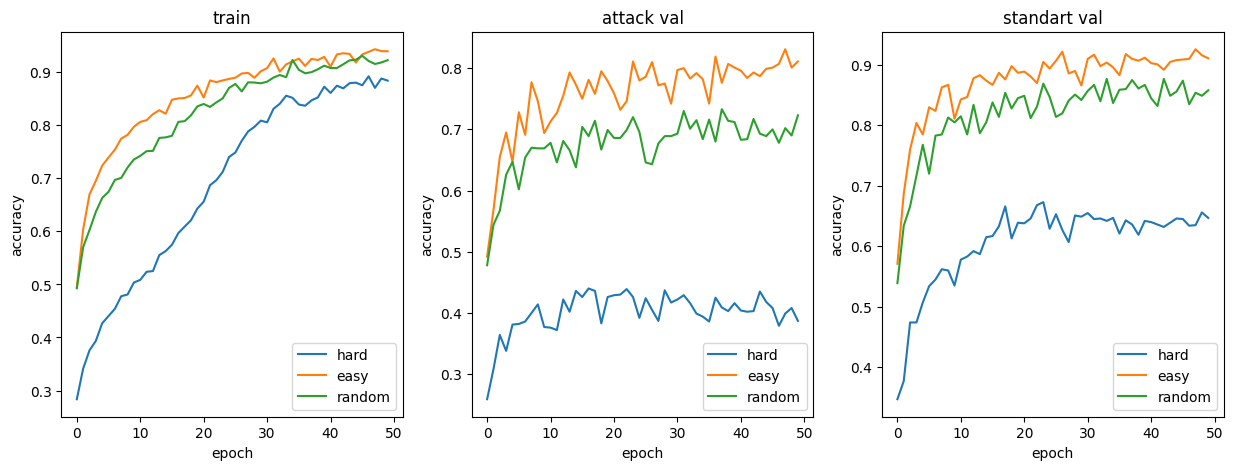

In [19]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for label in labels:
  axes[0].plot(range(epochs),acc_train_history[label],label=label)
  axes[1].plot(range(epochs),acc_pgd_val_history[label],label=label)
  axes[2].plot(range(epochs),acc_st_val_history[label],label=label)

for ax in axes:
  ax.legend()
  ax.set_xlabel('epoch')
  ax.set_ylabel('accuracy')

axes[0].set_title('train')
axes[1].set_title('attack val')
axes[2].set_title('standart val')
fig.savefig('3_subplots.png')